In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from typing import Tuple
from sklearn.feature_extraction.text import CountVectorizer

import project_tests as t

In [2]:
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to /home/iusztin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iusztin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iusztin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iusztin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')

del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [4]:
def normalize_article_id_name(article_id):
    return str(float(article_id))


# Normalize the article_id as a string representation of a float number. The rest of the notebook excepts it in this format.
df["article_id"] = df["article_id"].transform(normalize_article_id_name)
df_content["article_id"] = df_content["article_id"].transform(normalize_article_id_name)

In [5]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  object
 1   title       45993 non-null  object
 2   email       45976 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [7]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


In [8]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   object
dtypes: object(5)
memory usage: 41.4+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [9]:
filled_na_df = df.copy()
filled_na_df["email"] = filled_na_df["email"].fillna("unknown")
filled_na_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  object
 1   title       45993 non-null  object
 2   email       45993 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [10]:
user_num_articles_series = filled_na_df.groupby("email")["article_id"].count().rename("num_articles")
user_num_articles_series

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
unknown                                     17
Name: num_articles, Length: 5149, dtype: int64

In [11]:
user_num_articles_series["unknown"]

17

In [12]:
user_num_articles_series.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: num_articles, dtype: float64

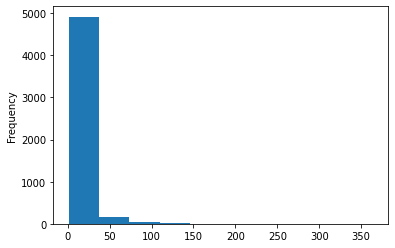

In [13]:
user_num_articles_series.plot.hist();

In [14]:
# Fill in the median and maximum number of user_article interactios below

median_val = user_num_articles_series.median()
max_views_by_user = user_num_articles_series.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.

In [15]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


In [16]:
for column in ["doc_body", "doc_description", "doc_full_name"]:
    mean_length = df_content[column].str.len().mean()
    print(f"{column}: {mean_length:.2f}")

doc_body: 8606.73
doc_description: 170.78
doc_full_name: 46.30


In [17]:
df_content[df_content.isna().any(axis=1)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206.0
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276.0
354,The search index lets you create flexible quer...,NaN,Build the search index in Cloudant,Live,354.0
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483.0
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507.0
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539.0
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637.0
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666.0
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704.0
768,Compose The Compose logo Articles Sign in Free...,NaN,Announcing the Data Browser for JanusGraph,Live,765.0


In [18]:
# Find and explore duplicate articles
duplicates = df_content[df_content.duplicated(subset=["article_id"])]
duplicates

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50.0
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221.0
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0


In [19]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=["article_id"])

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [20]:
unique_articles = len(df["article_id"].unique())
total_articles = len(df_content["article_id"].unique())
unique_users = len(df["email"].dropna().unique())
user_article_interactions = len(df)

In [21]:
print(f"The users interacted with {unique_articles} articles.")
print(f"There are {total_articles} total articles.")
print(f"The users interacted with {unique_articles * 100 / total_articles:.2f}% articles.\n")

print(f"There are {unique_users} users in the dataset")
print(f"There are {user_article_interactions} user-article interactions within the dataset.")

The users interacted with 714 articles.
There are 1051 total articles.
The users interacted with 67.94% articles.

There are 5148 users in the dataset
There are 45993 user-article interactions within the dataset.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
article_views_series = filled_na_df.groupby("article_id")["email"].count()
article_views_series.head()

article_id
0.0       14
100.0      9
1000.0    16
1004.0     7
1006.0    14
Name: email, dtype: int64

In [23]:
most_viewed_article_id = str(article_views_series.idxmax())
max_views = article_views_series.max()

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])

    return email_encoded


email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [26]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    top_article_ids = get_top_article_ids(n, df)
    top_articles = df[df["article_id"].isin(top_article_ids)]
    top_articles = top_articles[["article_id", "title"]]
    top_articles = top_articles.drop_duplicates()
    top_articles = top_articles["title"].tolist()

    return top_articles  # Return the top article titles from df (not df_content)


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    top_articles = df.groupby("article_id")["user_id"].count().sort_values(ascending=False).iloc[:n]
    top_articles = top_articles.index.tolist()

    return top_articles  # Return the top article ids

In [27]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [29]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''

    user_item = df.groupby(["user_id", "article_id"]).count().unstack()
    user_item.columns = user_item.columns.droplevel()
    user_item[user_item.notna()] = 1
    user_item = user_item.fillna(0)
    user_item = user_item.astype("int64")

    return user_item  # return the user_item matrix


user_item = create_user_item_matrix(df)

In [30]:
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [32]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    current_user_vec = user_item.loc[user_id, :]
    current_user_interaction_matrix = user_item @ current_user_vec.T
    # remove the own user's id
    current_user_interaction_matrix = current_user_interaction_matrix.drop(user_id)

    # sort by similarity
    most_similar_users = current_user_interaction_matrix.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = most_similar_users.index.tolist()

    return most_similar_users  # return a list of the users in order from most to least similar


In [33]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [34]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_names = df[df["article_id"].isin(article_ids)]
    article_names = article_names[["article_id", "title"]]
    article_names = article_names.drop_duplicates()
    article_names = article_names["title"].tolist()

    return article_names  # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_name - (list) a list of article names associated with the list of article ids
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_ids = user_item.loc[user_id]
    article_ids = article_ids[article_ids == 1].index.tolist()
    article_names = get_article_names(article_ids)

    return article_ids, article_names  # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    similar_users = find_similar_users(user_id)
    seen_movie_ids, _ = get_user_articles(user_id)

    recs = np.array([], dtype="object")
    for user_id in similar_users:
        article_ids, article_names = get_user_articles(user_id)
        article_ids = np.setdiff1d(article_ids, seen_movie_ids)

        recs = np.append(recs, article_ids, axis=0)
        recs = pd.unique(recs)

        if len(recs) >= m:
            break

    recs = recs[:m]
    recs = recs.tolist()

    return recs  # return your recommendations for this user_id

In [35]:
# Check Results
get_article_names(user_user_recs(1, 10))  # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [36]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(
    ['using deep learning to reconstruct high-resolution audio',
     'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model',
     'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding',
     'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(
    ['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery',
     'use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(
    ['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery',
     'use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio',
                                            'build a python app on the streaming analytics service',
                                            'gosales transactions for naive bayes model',
                                            'healthcare python streaming application demo',
                                            'use r dataframes & ibm watson natural language understanding',
                                            'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [37]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    current_user_vec = user_item.loc[user_id]
    similarity_df = user_item @ current_user_vec
    similarity_df = similarity_df.drop(user_id)
    similarity_df = similarity_df.rename("similarity")
    similarity_df = similarity_df.reset_index()

    user_articles_views_count = df.groupby("user_id")["article_id"].count().rename("num_interactions").reset_index()
    similarity_df = similarity_df.merge(user_articles_views_count, how="left", on="user_id")

    neighbors_df = similarity_df.sort_values(by=["similarity", "num_interactions"], ascending=False)
    neighbors_df = neighbors_df.rename(columns={"user_id": "neighbor_id"})

    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    similar_users = get_top_sorted_users(user_id)
    seen_article_ids, seen_article_names = get_user_articles(user_id)

    recs = {
        "article_id": [],
        "title": [],
    }
    for neighbor_data in similar_users.itertuples():
        article_ids, article_names = get_user_articles(neighbor_data.neighbor_id)
        article_ids, article_names = np.array(article_ids), np.array(article_names)

        valid_article_ids = np.where(~np.isin(article_ids, seen_article_ids))[0]
        article_ids = article_ids[valid_article_ids]
        article_names = article_names[valid_article_ids]

        recs["article_id"].extend(article_ids)
        recs["title"].extend(article_names)

        if len(recs["article_id"]) >= m:
            break

    if len(recs["article_id"]) > m:
        recs = pd.DataFrame(data=recs)
        num_article_views = df.groupby("article_id")["user_id"].count().rename("num_article_views").reset_index()
        recs = recs.merge(num_article_views, how="left", on="article_id")
        recs = recs.sort_values(by="num_article_views", ascending=False)
        recs = recs.iloc[:m]

        recs = {
            "article_id": recs["article_id"].values.tolist(),
            "title": recs["title"].values.tolist()
        }

    rec_names = recs["title"]
    recs = recs["article_id"]

    return recs, rec_names

In [38]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['analyzing data by using the sparkling.data library features', 'super fast string matching in python', 'tensorflow quick tips', 'insights from new york car accident reports', 'uci: sms spam collection', 'model bike sharing data with spss', 'occupation (2015): united states demographic measures', 'apache spark lab, part 3: machine learning', 'using machine learning to predict baseball injuries', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [39]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]["neighbor_id"]  # Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users(131).iloc[9]["neighbor_id"]  # Find the 10th most similar user to user 131

In [40]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Unfortunately, we can't build the user-article interaction matrix for new users. The user didn't interact with any article; therefore, the similarity score would be `0` for all the possible neighbors. Thus, we can't use the user-user-based collaborative filtering method we just built in this scenario. With what we have so far, a possible solution is to recommend a list of the top articles within our database. It won't be personalized, but at least it will get some articles validated by the other users. Other suggestions we don't have implemented yet would be adding some `knowledge` to our database. We could do that by asking the user, when he joins the platform, for some topics he might enjoy. Therefore, we could apply some knowledge base techniques to recommend some more personalized content.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [41]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)


In [42]:
assert set(new_user_recs) == set(
    ['1314.0', '1429.0', '1293.0', '1427.0', '1162.0', '1364.0', '1304.0', '1170.0', '1431.0',
     '1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [43]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [44]:
df["article_id"].describe()

count      45993
unique       714
top       1429.0
freq         937
Name: article_id, dtype: object

In [45]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


In [46]:
df_content["article_id"].describe()

count     1051
unique    1051
top        0.0
freq         1
Name: article_id, dtype: object

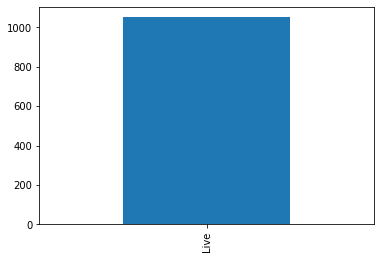

In [47]:
df_content["doc_status"].value_counts().plot.bar();

Because all the articles are labeled as "Live" the "doc_status" column is not useful.

In [48]:
def tokenize(text):
    """Function to tokenize an article title

    INPUT:
        text (str) The text to tokenize.

    OUTPUT:
        tokens (list) a list of words
    """

    # Normalize.
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    # Tokenize.
    tokens = word_tokenize(text)

    # Clean and lemmatize.
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(word) for word in tokens
        if word not in stopwords.words("english")
    ]

    # To avoid the dimensionality curse, filter all the words with a length less than 2.
    tokens = [token for token in tokens if len(token) > 2]

    return tokens


def create_content_article_matrix(
        df_content: pd.DataFrame,
        df: pd.DataFrame,
        vectorize_column: str = "doc_full_name"
) -> pd.DataFrame:
    # df_content DataFrame does not contain all the articles, therefore where it has missing data add the article title from the df interaction DataFrame.
    to_vectorize_df = pd.merge(
        df[["article_id", "title"]].drop_duplicates(subset=["article_id"]),
        df_content[["article_id", vectorize_column]].drop_duplicates(subset=["article_id"]),
        how="outer",
        on="article_id"
    )
    to_vectorize_df[vectorize_column] = to_vectorize_df[vectorize_column].fillna(to_vectorize_df["title"])

    vectorizer = CountVectorizer(tokenizer=tokenize)
    vectorized_data = vectorizer.fit_transform(to_vectorize_df[vectorize_column].values)
    vectorized_data = vectorized_data.toarray()
    vectorized_data = pd.DataFrame(data=vectorized_data, columns=vectorizer.get_feature_names_out())

    article_df = pd.concat([
        to_vectorize_df[["article_id"]],
        vectorized_data,
    ], axis=1)
    article_df = article_df.set_index("article_id")

    return article_df

In [49]:
def get_top_similar_articles(article_id: str, content_article_df: pd.DataFrame, df: pd.DataFrame, minimum_similarity_score: int = 3) -> Tuple[list, list]:
    '''
    INPUT:
        article_id: The article_id to which we want to see the most similar content.
        df: DataFrame that contains the raw content information about the articles.
        content_article_df: DataFrame that contains the content article vectors.
        minimum_similarity_score: The minimum similarity score we accept.

    OUTPUT:
        A list of n_count recommended articles ids sorted to how similar are relative to article_id.
    '''

    # If the article is new we cannot make any recommendations.
    if article_id not in content_article_df.index:
        return [], []

    current_article_vec = content_article_df.loc[article_id]
    similarities = content_article_df @ current_article_vec
    similarities = similarities.drop(article_id)
    similarities = similarities.sort_values(ascending=False)
    similarities = similarities[similarities >= minimum_similarity_score]

    articles_ids = pd.unique(similarities.index).tolist()
    articles = get_article_names(articles_ids, df)

    return articles_ids, articles


def make_content_recs(
        user_id: str,
        content_article_df: pd.DataFrame,
        df: pd.DataFrame,
        n_count: int = 10,
        minimum_similarity_score: int = 3
) -> Tuple[list, list]:
    '''
    INPUT:
        user_id: The user to which we want to recommend content to.
        df: DataFrame that contains the raw content information about the articles.
        content_article_df: DataFrame that contains the content article vectors.
        n_count: The number of articles to recommend.
        minimum_similarity_score: The minimum accepted similarity between articles.

    OUTPUT:
        A list of n_count recommended articles ids sorted to how similar are relative to article_id.
    '''

    seen_articles_df = df.groupby(["user_id", "article_id"], as_index=False)["title"].count().rename(columns={"title": "views"})
    seen_articles_df = seen_articles_df[seen_articles_df["user_id"] == user_id]
    if len(seen_articles_df) == 0:
        return get_top_article_ids(n_count, df), get_top_articles(n_count, df)

    seen_articles_df = seen_articles_df.sort_values(by=["views"], ascending=False)
    seen_articles_series = seen_articles_df["article_id"]
    seen_article_names = get_article_names(seen_articles_series.values, df)

    recommendations_ids = []
    recommendations = []
    for article_id in seen_articles_series:
        article_ids, article_names = get_top_similar_articles(
            article_id,
            content_article_df,
            df,
            minimum_similarity_score=minimum_similarity_score
        )
        article_ids = np.setdiff1d(article_ids, seen_articles_series)
        article_names = np.setdiff1d(article_names, seen_article_names)

        recommendations_ids.extend(article_ids.tolist())
        recommendations.extend(article_names.tolist())

        if len(recommendations) >= n_count:
            break
    recommendations = recommendations[:n_count]

    return recommendations_ids, recommendations

In [50]:
content_article_df = create_content_article_matrix(df_content, df)
content_article_df.head()

,000,100,1000,1854,1948,1983,1985,1990,1995,2003,...,xml2,year,yolo,york,youtube,zapier,zctas,zendesk,zero,zip
article_id,,,,,,,,,,,,,,,,,,,,,
1430.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1314.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1429.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1338.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1276.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Firstly, we had to build a content vector for every article. We built a bag of word vectors for all the articles for simplicity. We used the `doc_full_name` column. Also, because in the interaction matrix, there were more articles than in the content matrix, we used the `title` column from the interaction matrix to fill in the missing values. By design, we can easily change the `doc_full_name` to other columns.<br/><br/>After, we iterated through all the articles that a user seen, sorted based on the most viewed ones, and took the first `n` articles that are similar to the viewed content.<br/><br/>For the cold start problem, when a user haven't seen any article, we just recommended the most viewed articles within our data.<br/><br/>We could have augmented the article content vectors by running a pretrained sentiment analysis model or a genre classification model.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [51]:
# make recommendations for a brand-new user
df["user_id"].describe()

count    45993.000000
mean      2300.918314
std       1712.658385
min          1.000000
25%        621.000000
50%       2330.000000
75%       3835.000000
max       5149.000000
Name: user_id, dtype: float64

In [52]:
make_content_recs("100000", content_article_df, df)[1]

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [53]:
# make a recommendations for a user who only has interacted with article id '1427.0'
article_1427_df = df[df["article_id"] == "1427.0"].copy()
article_1427_df = article_1427_df.iloc[:2]
article_1427_df["user_id"] = "10000"
df_new = pd.concat([df, article_1427_df], axis=0)
df_new

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148
45992,16.0,higher-order logistic regression for large dat...,5149
42,1427.0,"use xgboost, scikit-learn & ibm watson machine...",10000


In [54]:
make_content_recs("10000", content_article_df, df_new)[1]

['66855    migration from ibm bluemix data connect api (a...\nName: title, dtype: object',
 'analyze facebook data using ibm watson and watson studio',
 'apple, ibm add machine learning to partnership with watson-core ml coupling',
 'create a project for watson machine learning in dsx',
 'ensemble learning to improve machine learning results',
 'from local spark mllib model to cloud with watson machine learning',
 'ibm watson machine learning: get started',
 'python machine learning: scikit-learn tutorial',
 'style transfer experiments with watson machine learning',
 'the difference between ai, machine learning, and deep learning?']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [55]:
# Load the matrix here
user_item_matrix = pd.read_pickle('./data/user_item_matrix.p')

In [56]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [57]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

**We can perform SVD on this user-item matrix because it doesn't contain any NaNs. Because of the user-item interaction nature, this won’t be a problem. If a user interacted with an article, we have a 1, otherwise 0. Ultimately, we don't need to know a specific value from the user (e.g., the review). Therefore, a value will always differ from NaN in the matrix.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

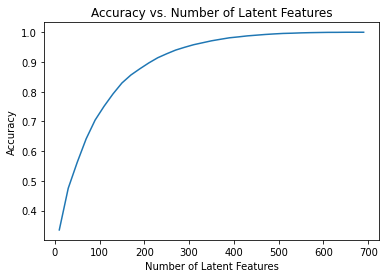

In [58]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_test, u_new_test, vt_new_test = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new_test, s_new_test), vt_new_test))

    # compute error for each prediction to actual value
    diffs_test = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)

plt.plot(num_latent_feats, 1 - np.array(sum_errs_test) / df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [59]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [60]:
df_train.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [61]:
df_test.head()

,article_id,title,user_id
40000,1053.0,access mysql with python,4487
40001,1314.0,healthcare python streaming application demo,4487
40002,1424.0,use spark for python to load data and run sql ...,4487
40003,1176.0,build a python app on the streaming analytics ...,4487
40004,58.0,advancements in the spark community,4488


In [62]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for each column)
    test_idx - all the test user ids
    test_arts - all the test article ids

    '''

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()

    return user_item_train, user_item_test, test_idx, test_arts


def compute_matrix_density(user_item_df: pd.DataFrame) -> float:
    """
    Given a user-item interaction matrix compute the density of the matrix as a percentage.

    INPUT
    user_item_df - user-item interaction DataFrame

    OUTPUT
    density - density as a percentage
    """

    num_ones = user_item_df.sum().sum()
    num_total = user_item_df.shape[0] * user_item_df.shape[1]
    density = num_ones / num_total

    return density * 100

In [63]:
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [64]:
print(f"Total density train matrix: {compute_matrix_density(user_item_train):.2f}%")
print(f"Total density test matrix: {compute_matrix_density(user_item_test):.2f}%")

Total density train matrix: 0.91%
Total density test matrix: 1.14%


In [65]:
old_users = np.intersect1d(user_item_test.index.values, user_item_train.index.values)
len(old_users)

20

In [66]:
new_users = np.setdiff1d(user_item_test.index.values, user_item_train.index.values)
len(new_users)

662

In [67]:
old_articles = np.intersect1d(user_item_test.columns.values, user_item_train.columns.values)
len(old_articles)

574

In [68]:
new_articles = np.setdiff1d(user_item_test.columns.values, user_item_train.columns.values)
len(new_articles)

0

In [69]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20
d = 0

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [70]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [71]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [72]:
# Find train indices for all the test users that we can predict.
old_test_users_train_indices = np.where(np.isin(user_item_train.index, old_users))[0]
# Find train indices for all the test articles we can predict.
old_test_articles_train_indices = np.where(np.isin(user_item_train.columns, old_articles))[0]

In [73]:
# Keep only test data that is overlapped with the training data (aka old_users and old_articles).
old_user_item_test = user_item_test.loc[old_users, old_articles]

# Filter the u rows and vt columns that reflect the users and articles that are in the test split.
u_train_old_users = u_train[old_test_users_train_indices, :]
vt_train_old_articles = vt_train[:, old_test_articles_train_indices]

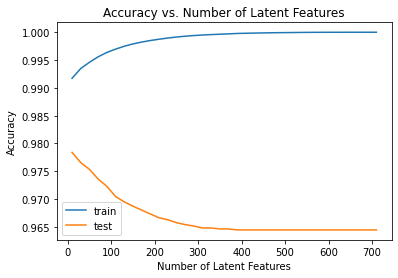

In [74]:
num_latent_feats = np.arange(10, s_train.shape[0] + 1, 20)

sum_errs_train = []
sum_errs_test = []
for k in num_latent_feats:
    # restructure with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_new_test, u_new_test, vt_new_test = np.diag(s_train[:k]), u_train_old_users[:, :k], vt_train_old_articles[:k, :]

    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_test_est = np.around(np.dot(np.dot(u_new_test, s_new_test), vt_new_test))

    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train.values, user_item_train_est)
    diffs_test = np.subtract(old_user_item_test.values, user_item_test_est)

    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)

    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)

sum_errs_train = np.array(sum_errs_train)
sum_errs_test = np.array(sum_errs_test)

plt.plot(num_latent_feats, 1 - sum_errs_train / (user_item_train.shape[0] * user_item_train.shape[1]), label="train")
plt.plot(num_latent_feats, 1 - sum_errs_test / (old_user_item_test.shape[0] * old_user_item_test.shape[1]),
         label="test")
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend();

In [75]:
print(
    f"The number of latent features that ended up with the lowest error are: {num_latent_feats[np.argmin(sum_errs_test)]} latent features")

The number of latent features that ended up with the lowest error are: 10 latent features


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**As we see in the graph above, the results are degrading as we keep adding latent features. This might occur because of the following factors:<br/>1. A small overlap between the train and test set (only 20 users). Therefore, we can't be sure if the calculated error is truly accurate.<br/>2. As we used a closed-form solution of SVD, we can see in the train-test graph that the algorithm have overfitted the train data. As we keep adding latent features, the values are more overfit on the train data.<br/>3. The density of both matrices is pretty low. Therefore, we have a high imbalance inclined towards 0s. Thus, as we keep adding latent features, the predictions are more biased towards 0.<br/><br/>There are three things that we might do to improve those issues:<br/>1. Create a better train-test split with a higher overlap.<br/> 2. Collect more data. <br/> 3. Use an iterative algorithm like FunkSVD, where we control the bias-variance tradeoff.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project!

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [76]:
from subprocess import call

call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "/home/iusztin/anaconda3/envs/ibm-assets-recommendation-engine/lib/python3.9/runpy.py", line 188, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/home/iusztin/anaconda3/envs/ibm-assets-recommendation-engine/lib/python3.9/runpy.py", line 147, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/home/iusztin/anaconda3/envs/ibm-assets-recommendation-engine/lib/python3.9/runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
  File "/home/iusztin/anaconda3/envs/ibm-assets-recommendation-engine/lib/python3.9/site-packages/nbconvert/__init__.py", line 4, in <module>
    from .exporters import *
  File "/home/iusztin/anaconda3/envs/ibm-assets-recommendation-engine/lib/python3.9/site-packages/nbconvert/exporters/__init__.py", line 3, in <module>
    from .html import HTMLExporter
  File "/home/iusztin/anaconda3/envs/ibm-assets-recommendation-engine/lib/py

1